In [1]:


import requests
from bs4 import BeautifulSoup
import pandas as pd

def append_df_to_excel(filename, df, sheet_name='Sheet1', startrow=None,
                       truncate_sheet=False, 
                       **to_excel_kwargs):
    from openpyxl import load_workbook

    # ignore [engine] parameter if it was passed
    if 'engine' in to_excel_kwargs:
        to_excel_kwargs.pop('engine')

    writer = pd.ExcelWriter(filename, engine='openpyxl')

    try:
        # try to open an existing workbook
        writer.book = load_workbook(filename)

        # get the last row in the existing Excel sheet
        # if it was not specified explicitly
        if startrow is None and sheet_name in writer.book.sheetnames:
            startrow = writer.book[sheet_name].max_row

        # truncate sheet
        if truncate_sheet and sheet_name in writer.book.sheetnames:
            # index of [sheet_name] sheet
            idx = writer.book.sheetnames.index(sheet_name)
            # remove [sheet_name]
            writer.book.remove(writer.book.worksheets[idx])
            # create an empty sheet [sheet_name] using old index
            writer.book.create_sheet(sheet_name, idx)

        # copy existing sheets
        writer.sheets = {ws.title:ws for ws in writer.book.worksheets}
    except FileNotFoundError:
        # file does not exist yet, we will create it
        pass

    if startrow is None:
        startrow = 0

    # write out the new sheet
    df.to_excel(writer, sheet_name, startrow=startrow, **to_excel_kwargs)

    # save the workbook
    writer.save()
    
reviewlist = []

    
def get_soup(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    return soup


def get_reviews(soup):
    reviews = soup.find_all('div', {'data-hook': 'review'})
    try:
        for item in reviews:
            review = {
            'Product': soup.title.text.replace('Amazon.in:Customer reviews:', '').strip(),
            'Custer Name':item.find('span',class_='a-profile-name').text.strip(),
            'Review Title': item.find('a', {'data-hook': 'review-title'}).text.strip(),
            'Rating':  float(item.find('i', {'data-hook': 'review-star-rating'}).text.replace('out of 5 stars', '').strip()),
            'Reviews': item.find('span', {'data-hook': 'review-body'}).text.strip(),
            }
            reviewlist.append(review)
    except:
        pass

for x in range(1,30):
    pg=str(x)
    url_main="https://www.amazon.in/Redmi-Prime-Storage-Display-Camera/product-reviews/B086984LJ4"
    url_split1="/ref=cm_cr_arp_d_paging_btm_next_"
    url_split2="?ie=UTF8&reviewerType=all_reviews&pageNumber="
    
    url_final = url_main+url_split1+pg+url_split2+pg
    print(url_final) 
    soup = get_soup(url_final)
    print(f'Getting page: {x}')
    get_reviews(soup)
    print(len(reviewlist))
    if not soup.find('li', {'class': 'a-disabled a-last'}):
        pass
    else:
        break

df = pd.DataFrame(reviewlist)
append_df_to_excel("final.xlsx", df, header=True, index=False)
print('End.')

https://www.amazon.in/Redmi-Prime-Storage-Display-Camera/product-reviews/B086984LJ4/ref=cm_cr_arp_d_paging_btm_next_1?ie=UTF8&reviewerType=all_reviews&pageNumber=1
Getting page: 1
10
https://www.amazon.in/Redmi-Prime-Storage-Display-Camera/product-reviews/B086984LJ4/ref=cm_cr_arp_d_paging_btm_next_2?ie=UTF8&reviewerType=all_reviews&pageNumber=2
Getting page: 2
20
https://www.amazon.in/Redmi-Prime-Storage-Display-Camera/product-reviews/B086984LJ4/ref=cm_cr_arp_d_paging_btm_next_3?ie=UTF8&reviewerType=all_reviews&pageNumber=3
Getting page: 3
30
https://www.amazon.in/Redmi-Prime-Storage-Display-Camera/product-reviews/B086984LJ4/ref=cm_cr_arp_d_paging_btm_next_4?ie=UTF8&reviewerType=all_reviews&pageNumber=4
Getting page: 4
30
https://www.amazon.in/Redmi-Prime-Storage-Display-Camera/product-reviews/B086984LJ4/ref=cm_cr_arp_d_paging_btm_next_5?ie=UTF8&reviewerType=all_reviews&pageNumber=5
Getting page: 5
40
https://www.amazon.in/Redmi-Prime-Storage-Display-Camera/product-reviews/B086984LJ4/r

# Analysing

In [2]:
import pandas as pd
import numpy as np
df=pd.read_excel(r'final.xlsx')

In [3]:
df.head()

,Product,Custer Name,Review Title,Rating,Reviews
0,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",Gopi,Oscem,5,Best mobile at this price range
1,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",NITISH RANJAN,redmi 9 prime,4,"good phone at this budget, but camera quality ..."
2,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",Arbaaz,Best in class @9999,5,Best budget smartphone.
3,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",ADIL.T.M,🤔prime.. prime🤭🤭🤭ᴄʰᵃⁿᵍᵉᵈ🙄🙄,4,We haven't seen the ‘Prime' branding on a Redm...
4,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",Sakib Hasan,value for money,5,nice camera


In [4]:
x=[]
x=df.Reviews

In [5]:
x

0                        Best mobile at this price range
1      good phone at this budget, but camera quality ...
2                                Best budget smartphone.
3      We haven't seen the ‘Prime' branding on a Redm...
4                                            nice camera
                             ...                        
215    Fingerprint reader is quick.Execellent battery...
216    I am one of old customer of Redmi.. i think it...
217    Best mobile at this price rangeGood looks hmmG...
218    Every thing is awesome in this price range exc...
219    Please don't buy this phone I have bought for ...
Name: Reviews, Length: 220, dtype: object

In [6]:
import re

REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(x)

In [7]:
df['Cleaned Reviews']=reviews_train_clean

In [8]:
df['Cleaned Reviews']

0                        best mobile at this price range
1      good phone at this budget but camera quality i...
2                                 best budget smartphone
3      we havent seen the ‘prime branding on a redmi ...
4                                            nice camera
                             ...                        
215    fingerprint reader is quickexecellent battery ...
216    i am one of old customer of redmi i think its ...
217    best mobile at this price rangegood looks hmmg...
218    every thing is awesome in this price range exc...
219    please dont buy this phone i have bought for m...
Name: Cleaned Reviews, Length: 220, dtype: object

In [9]:
import string
import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer

In [10]:
STOPWORDS=stopwords.words("english")

In [11]:
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

In [12]:
df.sample(5)

,Product,Custer Name,Review Title,Rating,Reviews,Cleaned Reviews
121,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",bookreader,Wifi Problem is the worst.,1,After 2 days of experience. I can sayThe wifi ...,after 2 days of experience i can saythe wifi c...
124,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",Krishna,Smply Awesome,5,Just Go ahead and PurchaseOver all its Good in...,just go ahead and purchaseover all its good in...
97,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",Tushar Patel,Worth to buy,5,"I had purchase this phone for my mother, she i...",i had purchase this phone for my mother she is...
33,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",RAVIKISHAN KUMAR,Pretty Compatible and Affordable,5,Redmi 9 Prime is a pretty compatible and good ...,redmi 9 prime is a pretty compatible and good ...
42,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",Aditya dhanraj,Best phone in budget,3,Phone is osm but its camera quality is not goo...,phone is osm but its camera quality is not goo...


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

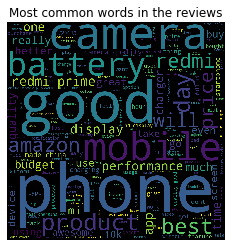

In [14]:
from wordcloud import WordCloud
wordcloud = WordCloud(height=1000, width=1000)
wordcloud = wordcloud.generate(' '.join(df['Cleaned Reviews'].tolist()))
plt.imshow(wordcloud)
plt.title("Most common words in the reviews")
plt.axis('off')
plt.show()
wordcloud =  wordcloud.to_file('static/wordcloud.png')

In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [16]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

In [17]:
def compound_score(text):
    comp=sentiment_analyzer_scores(text)
    return comp['compound']

In [18]:
df['sentiment_score']=df['Cleaned Reviews'].apply(lambda x:compound_score(x))

In [19]:
df.sample(4)

,Product,Custer Name,Review Title,Rating,Reviews,Cleaned Reviews,sentiment_score
42,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",Aditya dhanraj,Best phone in budget,3,Phone is osm but its camera quality is not goo...,phone is osm but its camera quality is not goo...,0.8512
185,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",Kishan gupta,Software issue,4,Gyro delay in pubg mobile... Can't play withou...,gyro delay in pubg mobile cant play without gy...,-0.4653
218,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",Ajay Verma,Every thing is awesome in this price range exc...,5,Every thing is awesome in this price range exc...,every thing is awesome in this price range exc...,0.3176
22,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",ABHISEK BHATTA,This product is very very very bad quality. Ma...,1,This product is very very very bad quality.Mad...,this product is very very very bad qualitymade...,-0.3955


In [20]:
def sentiment_category(score):
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

In [21]:
df['review_category']=df['sentiment_score'].apply(lambda x:sentiment_category(x))

In [22]:
df.sample(10)

,Product,Custer Name,Review Title,Rating,Reviews,Cleaned Reviews,sentiment_score,review_category
55,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",Amazon Customer,"Redmi 9 Prime is the best, nailing essentials,...",4,"The best part of this phone is1. The colour ""M...",the best part of this phone is1 the colour min...,0.9782,positive
192,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",Tejas R,"good,decent phone but not excellent",4,"In this price range, Full HD+ display is excel...",in this price range full hd+ display is excell...,-0.6723,negative
128,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",Narendra,Buy 18w charger again 🧐,3,"Need to purchase 18W charger with this mobile,...",need to purchase 18w charger with this mobile ...,-0.5423,negative
37,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",RAVIKISHAN KUMAR,Gaming and Multitasking Device,5,Redmi has come up with a great phone in the be...,redmi has come up with a great phone in the be...,0.7964,positive
105,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",Amisha,Best phone,5,"Design is good , handy phone , battery backup ...",design is good handy phone battery backup is...,0.8176,positive
16,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",ankit kumar,it is in the first place under 10000 price range.,5,"By good luck, I was able to get this phone in ...",by good luck i was able to get this phone in t...,0.9695,positive
56,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",Anand,Superb phone at,5,Superb phone at this budget and excellent valu...,superb phone at this budget and excellent valu...,0.8807,positive
135,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",RAVIKISHAN KUMAR,Compatible for everything,5,This is the best phone you can get for multita...,this is the best phone you can get for multita...,0.9456,positive
20,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",Divyankit,Only 13 MP CAMERA AT 12000 not a good deal,1,I Quite Disappointed with it because1- In Box ...,i quite disappointed with it because1 in box ...,-0.5256,negative
70,"Redmi 9 Prime (Mint Green, 4GB RAM, 128GB Stor...",Nikhil Kulkarni,Scores over other mobiles in the sub-10k price...,4,Can say without a doubt that performance and f...,can say without a doubt that performance and f...,0.9904,positive


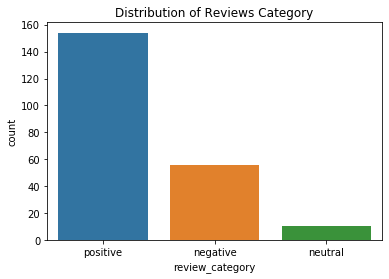

In [23]:
sns.countplot(df['review_category']).set_title("Distribution of Reviews Category")
plt.savefig('static/count_plot.png')

In [24]:
positive_reviews=df.loc[df['review_category']=='positive','Cleaned Reviews'].tolist() # extracting all positive reviews and converting to a list
positive_reviews[0:4]

['best mobile at this price range',
 'best budget smartphone',
 'we havent seen the ‘prime branding on a redmi smartphone in a really long time but now xiaomi has brought it back with the redmi 9 prime xiaomi explains that this model has been launched because its redmi note 9 series has become more expensive due to the gst hike and rupee dollar fluctuations the redmi 9 prime is priced below the redmi note 9 series and starts just below the rs 10000 price point has xiaomi gone overboard with cost cutting or does the redmi 9 prime offer you good value for money i review the new redmi 9 prime to find outat the beginning of our redmi 9 prime review we stated that the smartphone is a prime contender for the best smartphone under rs 10000 currently in india redmi 9 prime is a budget all rounder that ticks most boxes right with its value for money performance packagethe camera unit may not be the best but it gets the job done the lack of night mode is a bummer though you can pick xiaomi’s own

In [25]:
negative_reviews=df.loc[df['review_category']=='negative','Cleaned Reviews'].tolist() # extracting all negative reviews and converting to a list
negative_reviews[0:5]

['good phone at this budget but camera quality is not good',
 'good but camera quality not good',
 'only camera quality is poor  other all are good',
 'pros* perfect p2i protection*  low rate* good build quality for this price* android 10* miui 11 { waiting for miui 12 }cons* camera is below average* average display quality* no earphones in the box* over heating* takes very long time to charge battery* poor audio qualityif your are planning to buy for students { online class } its worthless',
 'i quite disappointed with it because1  in box only 10w charger is provided2  only 13 mp camera is available at 12000where as in narzo10 48mp main camera is available at 12000i suggest to only 10000rs vaireny']

# Positive Words in Positive Reviews

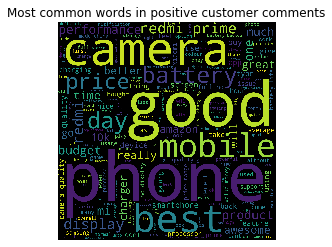

In [26]:
from wordcloud import WordCloud
wordcloud = WordCloud(height=2000, width=2000, background_color='black')
wordcloud = wordcloud.generate(' '.join(df.loc[df['review_category']=='positive','Cleaned Reviews'].tolist()))
plt.imshow(wordcloud)
plt.title("Most common words in positive customer comments")
plt.axis('off')
plt.show()


# Negative Words in Negative Reviews

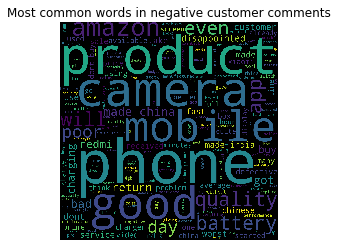

In [27]:
from wordcloud import WordCloud
wordcloud = WordCloud(height=2000, width=2000, background_color='black')
wordcloud = wordcloud.generate(' '.join(df.loc[df['review_category']=='negative','Cleaned Reviews'].tolist()))
plt.imshow(wordcloud)
plt.title("Most common words in negative customer comments")
plt.axis('off')
plt.show()

In [28]:
from collections import Counter
def getMostCommon(reviews_list,topn=20):
    reviews=" ".join(reviews_list)
    tokenised_reviews=reviews.split(" ")
    
    
    freq_counter=Counter(tokenised_reviews)
    return freq_counter.most_common(topn)

In [29]:
def plotMostCommonWords(reviews_list,topn=20,title="Common Review Words",color="blue",axis=None): #default number of words is given as 20
    top_words=getMostCommon(reviews_list,topn=topn)
    data=pd.DataFrame()
    data['words']=[val[0] for val in top_words]
    data['freq']=[val[1] for val in top_words]
    if axis!=None:
        sns.barplot(y='words',x='freq',data=data,color=color,ax=axis).set_title(title+" top "+str(topn))
    else:
        sns.barplot(y='words',x='freq',data=data,color=color).set_title(title+" top "+str(topn))

In [30]:
def generateNGram(text,n):
    tokens=text.split(" ")
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return ["_".join(ngram) for ngram in ngrams]

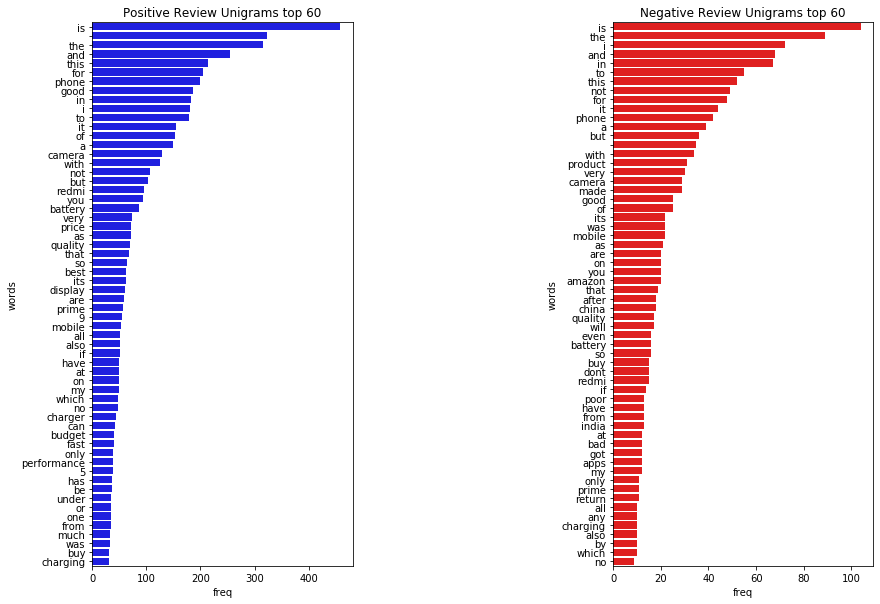

In [31]:
from matplotlib import rcParams

rcParams['figure.figsize'] = 14,10 ## Sets the heigth and width of image


fig,ax=plt.subplots(1,2)
fig.subplots_adjust(wspace=1.0) #Adjusts the space between the two plots
plotMostCommonWords(positive_reviews,60,"Positive Review Unigrams",axis=ax[0])
plotMostCommonWords(negative_reviews,60,"Negative Review Unigrams",color="red",axis=ax[1])
plt.savefig('static/unigram.png')